# Input Preparation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import librosa
import librosa.display


df=pd.read_csv('TinySOL/TinySOL_metadata.csv')
num_rows=df.shape[0]
num_samples=65025

mel_list=[]
for i in range(num_rows):
    signal,sr=librosa.load('TinySOL/'+df['Path'][i],sr=44100)
    if signal.shape[0]>num_samples:
        signal=signal[:num_samples]
    elif signal.shape[0]<num_samples:
        signal=np.pad(signal,(0,num_samples-signal.shape[0]),'constant')
    mel = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=2048, hop_length=512, n_mels=32)
    mel_dB = librosa.power_to_db(mel)
    mel_list.append(mel_dB)
X=np.array(mel_list)
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
X.shape



/var/folders/2_/j7xmh96x17xd8c5p8nxlsq340000gn/T/ipykernel_27131/2998324494.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


(2913, 32, 128, 1)

In [2]:
from sklearn.preprocessing import LabelEncoder

target_values = df['Instrument (in full)']
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(target_values)
num_classes=len(np.unique(y))
num_classes

14

# Preprocessing

In [3]:
from sklearn.model_selection import train_test_split

X_norm=X/np.max(np.abs(X))

X_train1, X_test, y_train1, y_test = train_test_split(X_norm, y, test_size=0.25,random_state=0)


# CNN Model

In [4]:
from tensorflow.keras import models,layers,callbacks
import tensorflow as tf

def CNN(X_train,y_train,X_val,y_val,epochs):
    model = models.Sequential(
    [
        layers.Conv2D(16, (3, 3), padding='same',strides=(1,1), input_shape=(32,128,1)),
        layers.BatchNormalization(),
        layers.ReLU(),

        layers.MaxPooling2D((2, 2),strides=(2,2)),

        layers.Conv2D(32, (3, 3),strides=(1,1) ,padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),

        layers.MaxPooling2D((2, 2),strides=(2,2)),

        layers.Flatten(),
        
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.BatchNormalization(),

        layers.Dense(num_classes,activation='softmax'),
    ])
    model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
    
    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor='val_accuracy', 
        factor=0.1, 
        patience=5, 
        verbose=1, 
        mode='auto', 
        min_delta=0.001, 
        cooldown=0, 
        min_lr=0
    )
    
    history=model.fit(X_train,y_train,validation_data=(X_val,y_val),callbacks=[reduce_lr],epochs=epochs)
    return model,history



In [5]:
def plot(history,target_type):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.suptitle('Plots for ' + target_type)
    plt.show()

In [6]:
model1,history1=CNN(X_train1,y_train1,X_test,y_test,30)

Epoch 1/30
69/69 [==============================] - 3s 42ms/step - loss: 1.9090 - accuracy: 0.3988 - val_loss: 2.7088 - val_accuracy: 0.0850 - lr: 0.0010
Epoch 2/30
69/69 [==============================] - 3s 46ms/step - loss: 1.1745 - accuracy: 0.6694 - val_loss: 3.0522 - val_accuracy: 0.1385 - lr: 0.0010
Epoch 3/30
69/69 [==============================] - 3s 43ms/step - loss: 0.8646 - accuracy: 0.7821 - val_loss: 3.1952 - val_accuracy: 0.1207 - lr: 0.0010
Epoch 4/30
69/69 [==============================] - 3s 44ms/step - loss: 0.7331 - accuracy: 0.8182 - val_loss: 3.5892 - val_accuracy: 0.0905 - lr: 0.0010
Epoch 5/30
69/69 [==============================] - 3s 46ms/step - loss: 0.6991 - accuracy: 0.8114 - val_loss: 2.6046 - val_accuracy: 0.1468 - lr: 0.0010
Epoch 6/30
69/69 [==============================] - 3s 51ms/step - loss: 0.5058 - accuracy: 0.8768 - val_loss: 2.0008 - val_accuracy: 0.3045 - lr: 0.0010
Epoch 7/30
69/69 [==============================] - 3s 46ms/step - loss: 0.4

In [7]:
model1.evaluate(X_test,y_test)

23/23 [==============================] - 0s 11ms/step - loss: 0.0679 - accuracy: 0.9781


[0.06793765723705292, 0.9780521392822266]

In [8]:
pred_array= model1.predict(X_norm)

92/92 [==============================] - 1s 11ms/step


# Dataset Class

In [9]:
import os
class general_dataset:

    def __init__(self,index):
        self.index=index

    def filename(self):
        path = df['Path'].iloc[self.index]
        filename = os.path.basename(path)
        return filename 
    
    def audio_file(self):
        auido_file,_=librosa.load('TinySOL/'+df['Path'][self.index],sr=44100)
        return auido_file.reshape(1,auido_file.shape[0])
    
    def mel(self):
        mel = librosa.feature.melspectrogram(y=self.audio_file(), sr=44100, n_fft=2048, hop_length=512, n_mels=32)
        mel_dB = librosa.power_to_db(mel)
        return mel_dB
    
    def Dict(self):
        ground_truth= label_encoder.inverse_transform([y[self.index]])
        pseudo_label= label_encoder.inverse_transform([np.argmax(pred_array[self.index])])
        Dict={'file':self.filename(),'audio':self.audio_file(),'mel':self.mel(),'gt':ground_truth,'pseudo':pseudo_label}
        return Dict


In [10]:
y_pred = np.array([label_encoder.transform(general_dataset(i).Dict()['pseudo']) for i in range(num_rows)]).flatten()
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_norm, y_pred, test_size=0.20,random_state=0)


In [11]:
model2,history2=CNN(X_train2,y_train2,X_test,y_test,30)

Epoch 1/30
73/73 [==============================] - 3s 40ms/step - loss: 1.6627 - accuracy: 0.4845 - val_loss: 2.6426 - val_accuracy: 0.0933 - lr: 0.0010
Epoch 2/30
73/73 [==============================] - 3s 40ms/step - loss: 0.9333 - accuracy: 0.7442 - val_loss: 3.1608 - val_accuracy: 0.0947 - lr: 0.0010
Epoch 3/30
73/73 [==============================] - 3s 41ms/step - loss: 0.6672 - accuracy: 0.8279 - val_loss: 3.1277 - val_accuracy: 0.1481 - lr: 0.0010
Epoch 4/30
73/73 [==============================] - 3s 40ms/step - loss: 0.4833 - accuracy: 0.8871 - val_loss: 2.3987 - val_accuracy: 0.2730 - lr: 0.0010
Epoch 5/30
73/73 [==============================] - 3s 45ms/step - loss: 0.4147 - accuracy: 0.8936 - val_loss: 2.3291 - val_accuracy: 0.3128 - lr: 0.0010
Epoch 6/30
73/73 [==============================] - 3s 42ms/step - loss: 0.3511 - accuracy: 0.9167 - val_loss: 1.2523 - val_accuracy: 0.5802 - lr: 0.0010
Epoch 7/30
73/73 [==============================] - 3s 43ms/step - loss: 0.3

In [12]:
model2.evaluate(X_test,y_test)

23/23 [==============================] - 0s 11ms/step - loss: 0.0854 - accuracy: 0.9781


[0.08535580337047577, 0.9780521392822266]

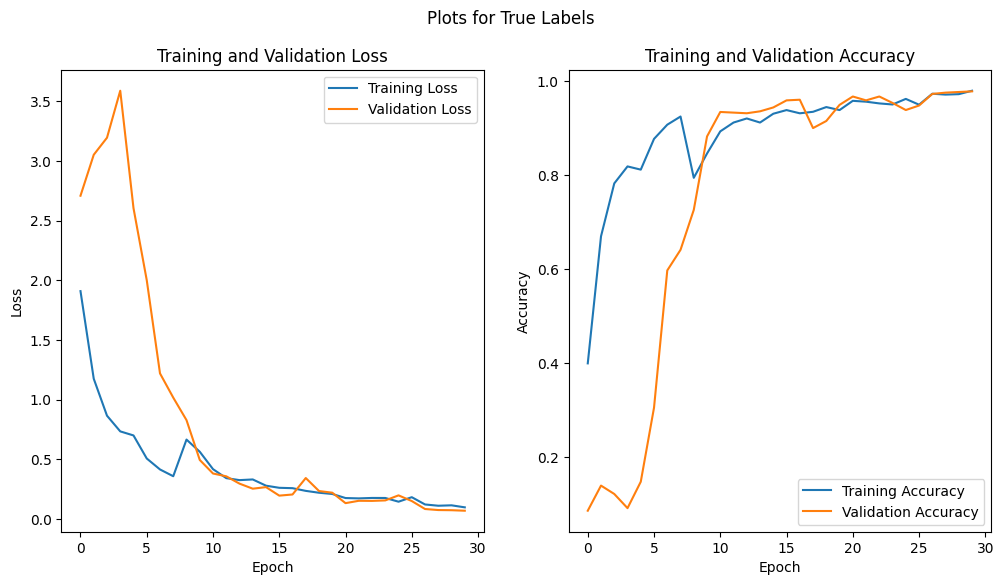

In [13]:
plot(history=history1,target_type='True Labels')

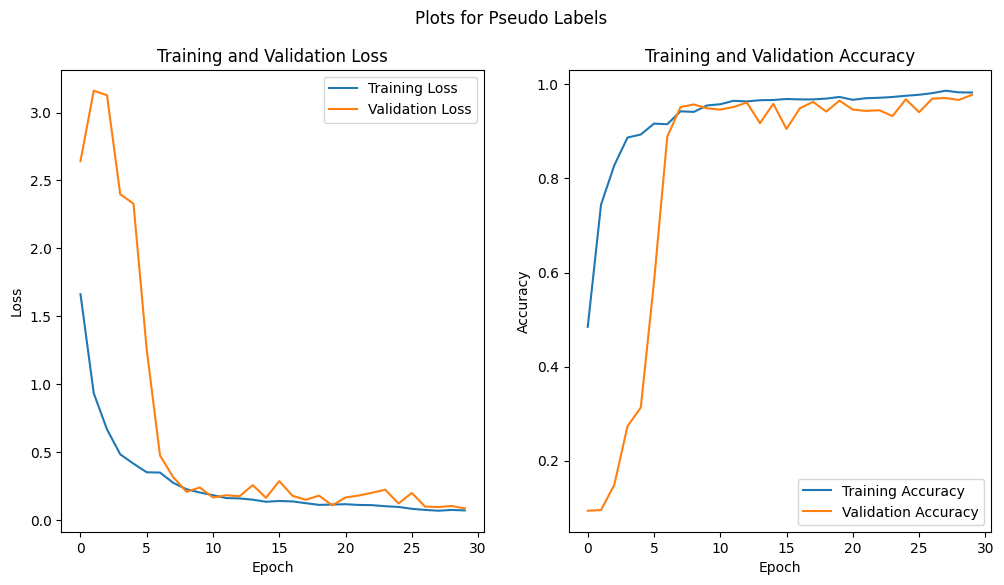

In [14]:
plot(history=history2,target_type='Pseudo Labels')

In [15]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model1)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/2_/j7xmh96x17xd8c5p8nxlsq340000gn/T/tmpxvliwcql/assets


INFO:tensorflow:Assets written to: /var/folders/2_/j7xmh96x17xd8c5p8nxlsq340000gn/T/tmpxvliwcql/assets
2024-06-03 22:39:55.545256: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-06-03 22:39:55.545443: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-06-03 22:39:55.546492: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/2_/j7xmh96x17xd8c5p8nxlsq340000gn/T/tmpxvliwcql
2024-06-03 22:39:55.548943: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-06-03 22:39:55.548951: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/2_/j7xmh96x17xd8c5p8nxlsq340000gn/T/tmpxvliwcql
2024-06-03 22:39:55.554892: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-06-03 22:39:55.557436: I tensorflow/cc/saved_model/load